# Packages

In [52]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from py_vollib.black_scholes_merton import black_scholes_merton as black_scholes_merton
from py_vollib.black_scholes_merton.greeks.numerical import delta, theta, vega, rho, gamma
from scipy.interpolate import griddata, RegularGridInterpolator

import datetime
import bisect

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')
sns.set_style('darkgrid')

# Testing with AAPL

In [53]:
aapl = yf.Ticker("AAPL")
aapl.options

('2025-03-07',
 '2025-03-14',
 '2025-03-21',
 '2025-03-28',
 '2025-04-04',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-10-17',
 '2025-12-19',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17')

In [55]:
optionchain = aapl.option_chain('2025-04-04')
optionchain.calls.head(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250404C00100000,2025-02-20 14:30:04+00:00,100.0,146.58,140.00,143.85,0.0,0.0,NaN,0,1.109379,True,REGULAR,USD
1,AAPL250404C00140000,2025-02-24 19:37:23+00:00,140.0,108.87,100.25,104.00,0.0,0.0,1.0,2,0.831056,True,REGULAR,USD
2,AAPL250404C00180000,2025-02-27 19:32:53+00:00,180.0,61.36,60.65,64.35,0.0,0.0,1.0,2,0.560551,True,REGULAR,USD
3,AAPL250404C00185000,2025-02-14 18:08:42+00:00,185.0,60.83,55.75,58.45,0.0,0.0,NaN,2,0.630863,True,REGULAR,USD
4,AAPL250404C00190000,2025-02-20 16:26:53+00:00,190.0,57.40,50.80,54.50,0.0,0.0,NaN,2,0.668216,True,REGULAR,USD


# Get Option Chain

In [90]:
def get_rfr_from_box_combo(date_df):
    underlying = date_df["underlying"].iloc[0]
    strikes = sorted(date_df["strike"].unique())

    n = len(strikes)
    if n < 3:
        lower = 0
        upper = n - 1
    else:
        index = bisect.bisect_left(strikes, underlying)
        lower, upper = 0, 0
        if index == 0: 
            lower = 0
            upper = 2
        elif index == n: 
            lower = n - 3
            upper = index - 1
        else:
            lower = index - 1
            upper = index + 1
    
    lower_strike = strikes[lower]
    upper_strike = strikes[upper]
    box_combo_price = date_df.query("is_call == 1 & strike == @lower_strike")["midpoint"].item() \
                        - date_df.query("is_call == 1 & strike == @upper_strike")["midpoint"].item() \
                        - date_df.query("is_call == 0 & strike == @lower_strike")["midpoint"].item() \
                        + date_df.query("is_call == 0 & strike == @upper_strike")["midpoint"].item()
    time_to_expiry = date_df.iloc[0]["time_to_expiry"].item()
    box_rate = -1 / time_to_expiry * np.log((box_combo_price) / (upper_strike - lower_strike))

    return box_rate

# def get_SPIBOR(): TODO, RFR from only box rate seems wrong


def calculate_greeks(date_df, current_price, dividend_yield, expiry_date):
    date_df["midpoint"] = (date_df["bid"] + date_df["ask"]) / 2
    date_df["underlying"] = current_price
    date_df["dividend_yield"] = dividend_yield / 100
    datetime_expiry_date = datetime.datetime.strptime(expiry_date, "%Y-%m-%d")
    datetime_expiry_date = datetime_expiry_date.replace(hour=16)
    diff_seconds = (datetime_expiry_date - datetime.datetime.today()).total_seconds()
    date_df["time_to_expiry"] = diff_seconds / 31536000
    date_df["averageImpliedVol"] = date_df.groupby('strike')['impliedVolatility'].transform('mean')
    # date_df["market_implied_rfr"] = get_rfr_from_box_combo(date_df)
    date_df["market_implied_rfr"] = 1.04113**(diff_seconds / 31536000) - 1
    # print(f'DEBUG: Greek params: midpoint = {date_df.iloc[0]["midpoint"]}, underlying = {date_df.iloc[0]["underlying"]}, \
    #       dividend_yield = {date_df.iloc[0]["dividend_yield"]}, time_to_expiry = {date_df.iloc[0]["time_to_expiry"]}\
    #         market_implied_rfr = {date_df.iloc[0]["market_implied_rfr"]}')
    date_df["delta"] = date_df.apply(
        lambda row: delta(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["gamma"] = date_df.apply(
        lambda row: gamma(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["theta"] = date_df.apply(
        lambda row: theta(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["vega"] = date_df.apply(
        lambda row: vega(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["rho"] = date_df.apply(
        lambda row: rho(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
       
    return date_df

def get_option_chain(ticker):
    yf_ticker = yf.Ticker(ticker)
    current_price = yf_ticker.history(period="1d")['Close'].iloc[-1]
    dividend_yield = yf_ticker.info.get("dividendYield")

    expiry_dates = yf_ticker.options
    to_ret_dict = {}
    for date in expiry_dates:
        print(f"Grabbing {date}")
        try:
            option_chain = yf_ticker.option_chain(date)
            call_df = option_chain.calls
            call_df["is_call"] = 1
            put_df = option_chain.puts
            put_df["is_call"] = 0
            date_df = pd.concat([call_df, put_df])
            date_df = calculate_greeks(date_df, current_price, dividend_yield, date)
            to_ret_dict[date] = date_df
        except KeyError as e:
            print(f"Failed grabbing {date} - exception = {e}")
    
    return to_ret_dict

In [91]:
aapl_option_chain_dict = get_option_chain("AAPL")

Grabbing 2025-03-07
Grabbing 2025-03-14
Grabbing 2025-03-21
Grabbing 2025-03-28
Grabbing 2025-04-04
Grabbing 2025-04-17
Grabbing 2025-05-16
Grabbing 2025-06-20
Grabbing 2025-07-18
Grabbing 2025-08-15
Grabbing 2025-09-19
Grabbing 2025-10-17
Grabbing 2025-12-19
Grabbing 2026-01-16
Grabbing 2026-03-20
Grabbing 2026-06-18
Grabbing 2026-12-18
Grabbing 2027-01-15
Grabbing 2027-06-17


In [92]:
print(aapl_option_chain_dict.keys())

dict_keys(['2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17'])


In [93]:
test_df = aapl_option_chain_dict["2025-04-04"]
display(test_df)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,is_call,midpoint,underlying,dividend_yield,time_to_expiry,averageImpliedVol,market_implied_rfr,delta,gamma,theta,vega,rho
0,AAPL250404C00100000,2025-02-20 14:30:04+00:00,100.0,146.58,140.00,143.85,0.000000,0.000000,NaN,0,1.109379,True,REGULAR,USD,1,141.925,241.839996,0.0041,0.093793,1.178227,0.003788,0.995319,0.000145,-0.013837,0.009356,0.092662
1,AAPL250404C00140000,2025-02-24 19:37:23+00:00,140.0,108.87,100.25,104.00,0.000000,0.000000,1.0,2,0.831056,True,REGULAR,USD,1,102.125,241.839996,0.0041,0.093793,0.754397,0.003788,0.993074,0.000328,-0.013213,0.013599,0.129660
2,AAPL250404C00180000,2025-02-27 19:32:53+00:00,180.0,61.36,60.65,64.35,0.000000,0.000000,1.0,2,0.560551,True,REGULAR,USD,1,62.500,241.839996,0.0041,0.093793,0.524175,0.003788,0.972179,0.001627,-0.034340,0.046788,0.162139
3,AAPL250404C00185000,2025-02-14 18:08:42+00:00,185.0,60.83,55.75,58.45,0.000000,0.000000,NaN,2,0.630863,True,REGULAR,USD,1,57.100,241.839996,0.0041,0.093793,0.544438,0.003788,0.954122,0.002371,-0.054856,0.070812,0.162381
4,AAPL250404C00190000,2025-02-20 16:26:53+00:00,190.0,57.40,50.80,54.50,0.000000,0.000000,NaN,2,0.668216,True,REGULAR,USD,1,52.650,241.839996,0.0041,0.093793,0.548711,0.003788,0.935320,0.003093,-0.073288,0.093101,0.162416
5,AAPL250404C00195000,2025-02-26 16:25:02+00:00,195.0,48.38,46.85,48.60,0.000000,0.000000,1.0,5,0.545415,True,REGULAR,USD,1,47.725,241.839996,0.0041,0.093793,0.474615,0.003788,0.939491,0.003394,-0.060020,0.088353,0.168288
6,AAPL250404C00200000,2025-02-28 19:19:44+00:00,200.0,39.75,40.95,43.60,-10.759998,-21.302710,1.0,3,0.496343,True,REGULAR,USD,1,42.275,241.839996,0.0041,0.093793,0.436773,0.003788,0.931103,0.004082,-0.061282,0.097787,0.171011
7,AAPL250404C00205000,2025-02-28 16:03:26+00:00,205.0,33.55,36.25,40.00,-8.010002,-19.273344,5.0,1,0.539677,True,REGULAR,USD,1,38.125,241.839996,0.0041,0.093793,0.447332,0.003788,0.898434,0.005342,-0.084767,0.131063,0.167673
8,AAPL250404C00210000,2025-02-27 20:53:33+00:00,210.0,28.10,32.40,34.35,-1.920000,-6.395736,1.0,30,0.447637,True,REGULAR,USD,1,33.375,241.839996,0.0041,0.093793,0.393866,0.003788,0.890383,0.006413,-0.078951,0.138522,0.170599
9,AAPL250404C00215000,2025-02-26 20:58:29+00:00,215.0,27.55,27.80,29.10,0.000000,0.000000,51.0,42,0.381354,True,REGULAR,USD,1,28.450,241.839996,0.0041,0.093793,0.356635,0.003788,0.870723,0.007961,-0.080542,0.155693,0.170670


# Get Straddle View

In [94]:
def get_straddle_df(option_chain_df):
    to_ret = pd.DataFrame()
    to_ret["strike"] = sorted(option_chain_df["strike"].unique())
    call_df = option_chain_df.query("is_call == 1")
    to_ret = to_ret.merge(call_df, how="left", on="strike")
    cols_to_drop = ["lastTradeDate", "contractSymbol", "lastPrice", "change", "percentChange",\
                    "contractSize","currency", "is_call", "underlying", "dividend_yield", "time_to_expiry", "market_implied_rfr", "averageImpliedVol"]
    cols_to_rename = {"bid" : "call_bid", "ask" : "call_ask", "volume" : "call_volume", "openInterest" : "call_openInterest", "midpoint" : "call_midpoint", "inTheMoney" : "call_inTheMoney",\
                    "impliedVolatility" : "call_IV", "delta" : "call_delta", "gamma" : "call_gamma", "theta" : "call_theta", "vega" : "call_vega", "rho" : "call_rho"}
    to_ret.drop(columns=cols_to_drop, inplace=True)
    to_ret.rename(columns=cols_to_rename, inplace=True)

    put_df = option_chain_df.query("is_call == 0")
    to_ret = to_ret.merge(put_df, how="left", on="strike")
    cols_to_drop = ["lastTradeDate", "contractSymbol", "lastPrice", "change", "percentChange",\
                    "contractSize","currency", "is_call", "underlying", "dividend_yield", "time_to_expiry", "market_implied_rfr", "averageImpliedVol"]
    cols_to_rename = {"bid" : "put_bid", "ask" : "put_ask", "volume" : "put_volume", "openInterest" : "put_openInterest", "midpoint" : "put_midpoint", "inTheMoney" : "put_inTheMoney",\
                    "impliedVolatility" : "put_IV", "delta" : "put_delta", "gamma" : "put_gamma", "theta" : "put_theta", "vega" : "put_vega", "rho" : "put_rho"}
    to_ret.drop(columns=cols_to_drop, inplace=True)
    to_ret.rename(columns=cols_to_rename, inplace=True)

    call_columns = [col for col in to_ret.columns if 'call' in col.lower()]
    call_columns.reverse()
    put_columns = [col for col in to_ret.columns if 'call' not in col.lower()]
    to_ret = to_ret[call_columns + put_columns]

    return to_ret

In [95]:
straddle_df = get_straddle_df(test_df)
display(straddle_df)

,call_rho,call_vega,call_theta,call_gamma,call_delta,call_midpoint,call_inTheMoney,call_IV,call_openInterest,call_volume,call_ask,call_bid,strike,put_bid,put_ask,put_volume,put_openInterest,put_IV,put_inTheMoney,put_midpoint,put_delta,put_gamma,put_theta,put_vega,put_rho
0,0.092662,0.009356,-0.013837,0.000145,0.995319,141.925,True,1.109379,0.0,NaN,143.85,140.00,100.0,0.00,0.45,NaN,3.0,1.247074,False,0.225,-0.004296,0.000145,-0.015515,0.009356,-0.001097
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,0.00,0.46,NaN,1.0,1.125004,False,0.230,-0.006969,0.000233,-0.022896,0.014379,-0.001779
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,0.00,0.68,1.0,1.0,1.067387,False,0.340,-0.010520,0.000352,-0.031319,0.020633,-0.002682
3,0.129660,0.013599,-0.013213,0.000328,0.993074,102.125,True,0.831056,2.0,1.0,104.00,100.25,140.0,0.00,0.11,1.0,4.0,0.677738,False,0.055,-0.006541,0.000328,-0.014477,0.013599,-0.001603
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,0.10,0.17,90.0,10.0,0.583989,False,0.135,-0.008216,0.000519,-0.013727,0.016629,-0.001981
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,0.13,0.19,399.0,115.0,0.556645,False,0.160,-0.009958,0.000644,-0.015518,0.019677,-0.002396
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,0.18,0.23,6.0,7.0,0.536626,False,0.205,-0.012977,0.000841,-0.018891,0.024765,-0.003122
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,0.11,0.26,3.0,11.0,0.515630,False,0.185,-0.016692,0.001087,-0.022607,0.030748,-0.004013
8,0.162139,0.046788,-0.034340,0.001627,0.972179,62.500,True,0.560551,2.0,1.0,64.35,60.65,180.0,0.25,0.30,12.0,25.0,0.487798,False,0.275,-0.027436,0.001627,-0.035188,0.046788,-0.006628
9,0.162381,0.070812,-0.054856,0.002371,0.954122,57.100,True,0.630863,2.0,NaN,58.45,55.75,185.0,0.29,0.34,30.0,30.0,0.458013,False,0.315,-0.045493,0.002371,-0.055653,0.070812,-0.011074


In [96]:
tol = 1e-2

delta_pcp = straddle_df["call_delta"] - straddle_df["put_delta"]
assert (np.isclose(delta_pcp, 1, atol=tol) | delta_pcp.isna()).all(), "Delta diff not equal to 1"

gamma_pcp = straddle_df["call_gamma"] - straddle_df["put_gamma"]
assert (np.isclose(gamma_pcp, 0, atol=tol) | gamma_pcp.isna()).all(), "Gamma diff not equal to 0"

theta_pcp = straddle_df["call_theta"] - straddle_df["put_theta"]
assert (np.isclose(theta_pcp, 0, atol=tol) | theta_pcp.isna()).all(), "Theta diff not equal to 0"

vega_pcp = straddle_df["call_vega"] - straddle_df["put_vega"]
assert (np.isclose(vega_pcp, 0, atol=tol) | vega_pcp.isna()).all(), "Vega diff not equal to 0"

# Vol (greeks) Surface

graphing the call implied vol surface across strike and expriy space.

In [97]:
def get_straddle_df_dict(option_chain_dict):
    straddle_df_dict = {}
    for date in option_chain_dict.keys():
        straddle_df_dict[date] = get_straddle_df(option_chain_dict[date])
    return straddle_df_dict

aapl_straddle_df_dict = get_straddle_df_dict(aapl_option_chain_dict)
print(aapl_straddle_df_dict.keys())
display(aapl_straddle_df_dict[list(aapl_straddle_df_dict.keys())[0]].head())

dict_keys(['2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17'])


,call_rho,call_vega,call_theta,call_gamma,call_delta,call_midpoint,call_inTheMoney,call_IV,call_openInterest,call_volume,call_ask,call_bid,strike,put_bid,put_ask,put_volume,put_openInterest,put_IV,put_inTheMoney,put_midpoint,put_delta,put_gamma,put_theta,put_vega,put_rho
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.01,200.0,1363.0,1.937500,False,0.005,-0.000151,0.000010,-0.001809,0.000184,-0.000007
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,0.0,0.01,309.0,309.0,1.718751,False,0.005,-0.000148,0.000011,-0.001567,0.000181,-0.000006
2,0.020178,0.006123,-0.091956,0.000264,0.992977,121.700,True,3.083987,2.0,NaN,123.35,120.05,120.0,0.0,0.01,3.0,456.0,1.562502,False,0.005,-0.006953,0.000264,-0.094446,0.006123,-0.000319
3,0.021330,0.014447,-0.251884,0.000585,0.981241,111.775,True,2.794925,3.0,1.0,113.40,110.15,130.0,0.0,0.71,50.0,59.0,2.152348,False,0.355,-0.018689,0.000585,-0.254355,0.014447,-0.000874
4,0.023563,0.006765,-0.079315,0.000372,0.992145,102.000,True,1.716798,45.0,35.0,103.90,100.10,140.0,0.0,0.71,10.0,317.0,1.919922,False,0.355,-0.007785,0.000372,-0.081767,0.006765,-0.000349


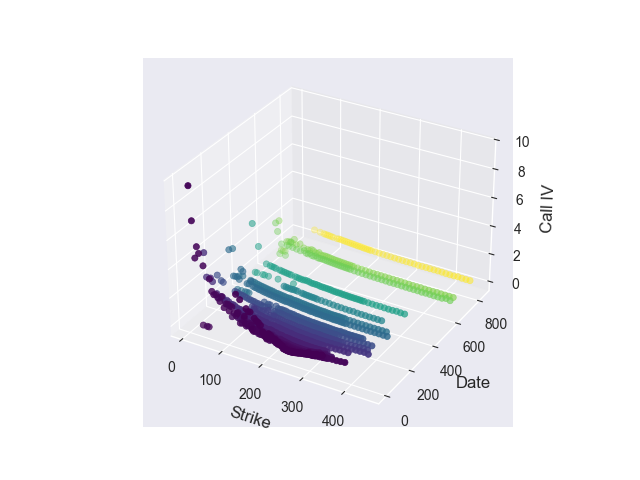

In [98]:
strikes = []
call_IVs = []
dates = []

for date, df in aapl_straddle_df_dict.items():
    strikes.extend(df['strike'].values)
    # print(df['strike'].values)
    call_IVs.extend(df['call_IV'].values)
    # print(f"DEBUG: {len(strikes)}, {len(call_IVs)}")
    dates.extend([date] * len(df))

strikes = np.array(strikes)
call_IVs = np.array(call_IVs)
dates = np.array(dates)

dates = pd.Series([datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates])
date_numbers = (dates - dates.min()).dt.days.to_numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(strikes, date_numbers, call_IVs, c=date_numbers, cmap='viridis')

ax.set_xlabel('Strike')
ax.set_ylabel('Date')
ax.set_zlabel('Call IV')

plt.show()

/var/folders/8r/qgk4_l1j20gfq28wvs_pxh2r0000gn/T/ipykernel_64225/1292162374.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(combined_df['strike'], combined_df['date'], combined_df['call_IV'], cmap='viridis')


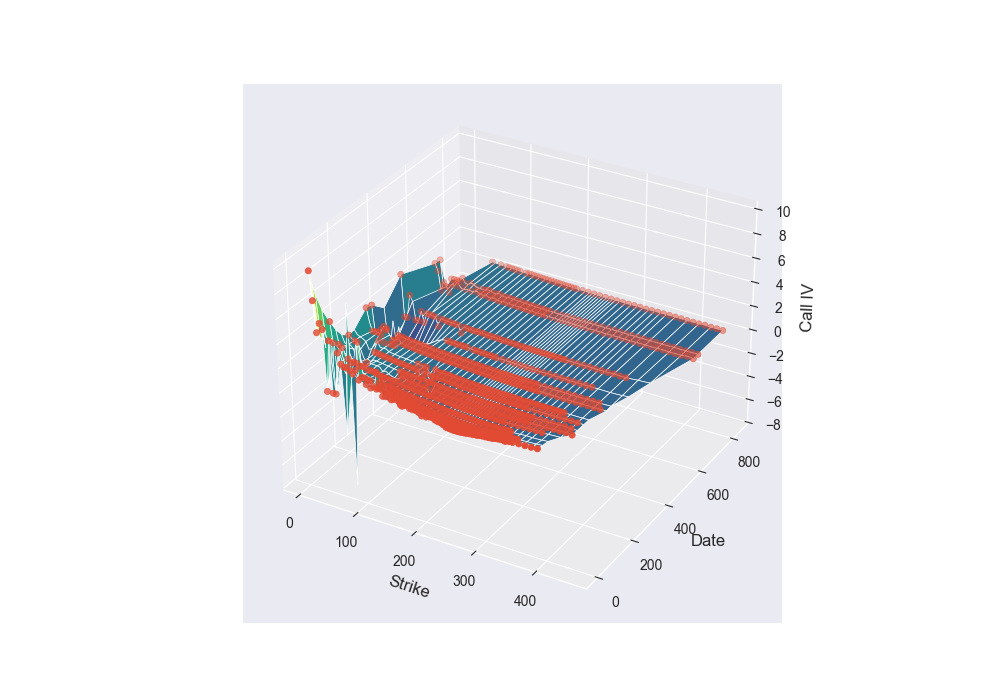

In [99]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Combine data into a single DataFrame
all_data = []

for date, df in aapl_straddle_df_dict.items():
    df['date'] = datetime.datetime.strptime(date, "%Y-%m-%d")
    all_data.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(all_data)
combined_df.dropna(subset=['call_IV'], inplace=True)
# Ensure 'strike' and 'date' are in numeric form
min_date = combined_df['date'].min()
combined_df['date'] = (combined_df['date'] - min_date).dt.days

combined_df['strike'] = pd.to_numeric(combined_df['strike'])
combined_df['date'] = pd.to_numeric(combined_df['date'])

# Create meshgrid for interpolation
# Unique strike values
strike_values = np.unique(combined_df['strike'])
# Unique date values (convert to a numerical representation)
date_values = np.unique(combined_df['date'])

# Create a meshgrid from the unique strike and date values
X, Y = np.meshgrid(strike_values, date_values)

# Flatten the meshgrid for interpolation
points = combined_df[['strike', 'date']].values
values = combined_df['call_IV'].values

# Interpolate using cubic interpolation
Z = griddata(points, values, (X, Y), method='cubic')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.scatter(combined_df['strike'], combined_df['date'], combined_df['call_IV'], cmap='viridis')

# Label axes
ax.set_xlabel('Strike')
ax.set_ylabel('Date')
ax.set_zlabel('Call IV')

plt.show()


In [100]:
def plot_greek_surface(straddle_df_dict, param_to_plot="call_IV", show_scatter=False):
    # Combine data into a single DataFrame
    all_data = []

    for date, df in straddle_df_dict.items():
        df['date'] = datetime.datetime.strptime(date, "%Y-%m-%d")
        all_data.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(all_data)
    combined_df.dropna(subset=[param_to_plot], inplace=True)
    # Ensure 'strike' and 'date' are in numeric form
    min_date = combined_df['date'].min()
    combined_df['date'] = (combined_df['date'] - min_date).dt.days

    combined_df['strike'] = pd.to_numeric(combined_df['strike'])
    combined_df['date'] = pd.to_numeric(combined_df['date'])

    # Create meshgrid for interpolation
    # Unique strike values
    strike_values = np.unique(combined_df['strike'])
    # Unique date values (convert to a numerical representation)
    date_values = np.unique(combined_df['date'])

    # Create a meshgrid from the unique strike and date values
    X, Y = np.meshgrid(strike_values, date_values)

    # Flatten the meshgrid for interpolation
    points = combined_df[['strike', 'date']].values
    values = combined_df[param_to_plot].values

    # Interpolate using cubic interpolation
    Z = griddata(points, values, (X, Y), method='cubic')

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis')
    if show_scatter:
        ax.scatter(combined_df['strike'], combined_df['date'], combined_df[param_to_plot], cmap='viridis')

    # Label axes
    ax.set_xlabel('Strike')
    ax.set_ylabel('Date')
    ax.set_zlabel(param_to_plot)

    plt.show()

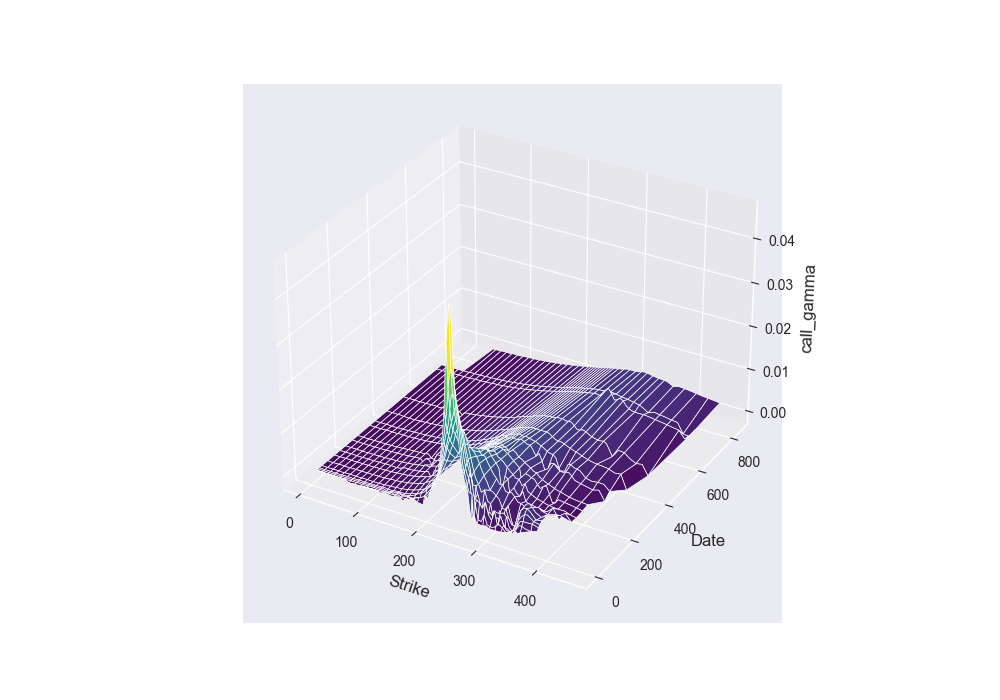

In [112]:
plot_greek_surface(aapl_straddle_df_dict, param_to_plot="call_gamma", show_scatter=False)

# Vol Skew

In [139]:
from scipy.interpolate import interp1d

def vol_interp(straddle_df, is_call=True, method="cubic"):
    iv = "call_IV" if is_call else "put_IV"
    df = straddle_df.dropna(subset=[iv])
    return interp1d(df["strike"], df[iv], kind=method)
    

In [140]:
aapl_straddle_df_dict["2025-04-04"].head()

,call_rho,call_vega,call_theta,call_gamma,call_delta,call_midpoint,call_inTheMoney,call_IV,call_openInterest,call_volume,call_ask,call_bid,strike,put_bid,put_ask,put_volume,put_openInterest,put_IV,put_inTheMoney,put_midpoint,put_delta,put_gamma,put_theta,put_vega,put_rho,date
0,0.092662,0.009356,-0.013837,0.000145,0.995319,141.925,True,1.109379,0.0,NaN,143.85,140.00,100.0,0.0,0.45,NaN,3.0,1.247074,False,0.225,-0.004296,0.000145,-0.015515,0.009356,-0.001097,2025-04-04
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,0.0,0.46,NaN,1.0,1.125004,False,0.230,-0.006969,0.000233,-0.022896,0.014379,-0.001779,2025-04-04
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,0.0,0.68,1.0,1.0,1.067387,False,0.340,-0.010520,0.000352,-0.031319,0.020633,-0.002682,2025-04-04
3,0.129660,0.013599,-0.013213,0.000328,0.993074,102.125,True,0.831056,2.0,1.0,104.00,100.25,140.0,0.0,0.11,1.0,4.0,0.677738,False,0.055,-0.006541,0.000328,-0.014477,0.013599,-0.001603,2025-04-04
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,0.1,0.17,90.0,10.0,0.583989,False,0.135,-0.008216,0.000519,-0.013727,0.016629,-0.001981,2025-04-04


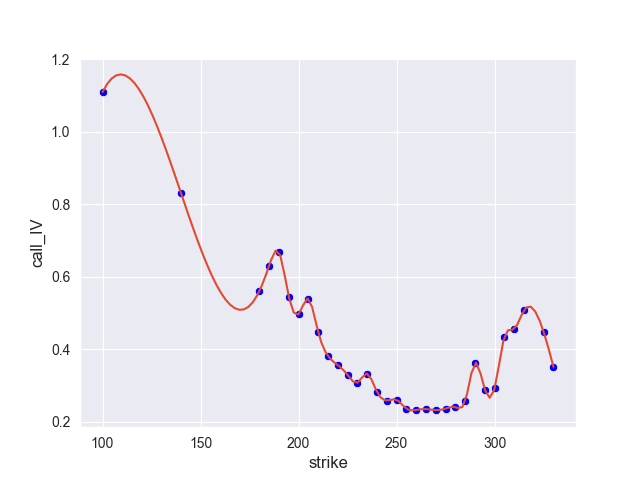

In [149]:
df = aapl_straddle_df_dict["2025-04-04"]
vol_spline = vol_interp(df)
strike_linspace = np.linspace(df["strike"].min(), df["strike"].max(), 100)
call_iv_spline = vol_spline(strike_linspace)

fig = plt.figure()
plt.plot(strike_linspace, call_iv_spline)
sns.scatterplot(df, x='strike',y='call_IV', color='blue')
plt.show()

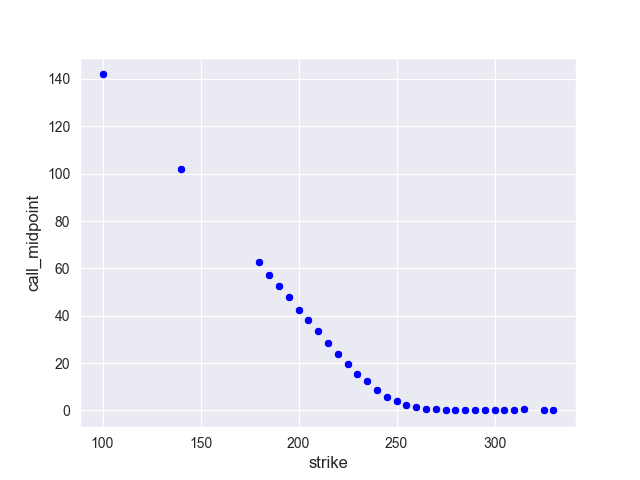

In [155]:
fig = plt.figure()
sns.scatterplot(df, x='strike',y='call_midpoint', color='blue')
plt.show(0)

# Vol Term Structure

In [114]:
aapl_straddle_df_dict

{'2025-03-07':     call_rho  call_vega  call_theta  call_gamma  call_delta  call_midpoint  \
 0        NaN        NaN         NaN         NaN         NaN            NaN   
 1        NaN        NaN         NaN         NaN         NaN            NaN   
 2   0.020178   0.006123   -0.091956    0.000264    0.992977        121.700   
 3   0.021330   0.014447   -0.251884    0.000585    0.981241        111.775   
 4   0.023563   0.006765   -0.079315    0.000372    0.992145        102.000   
 5   0.024376   0.007486   -0.084196    0.000433    0.991192         96.600   
 6   0.024860   0.013216   -0.166532    0.000726    0.983093         91.600   
 7   0.025794   0.012107   -0.136823    0.000732    0.984730         86.750   
 8   0.027291   0.000935   -0.003015    0.000091    0.999062         81.850   
 9   0.027622   0.010383   -0.094424    0.000762    0.987210         76.625   
 10  0.028423   0.011270   -0.096481    0.000885    0.985944         71.650   
 11  0.028767   0.018734   -0.175892  

In [159]:
def vol_interp_delta(straddle_df, is_call=True, method="cubic"):
    prefix = "call_" if is_call else "put_"
    iv = prefix + "IV"
    delta = prefix + "delta"
    df = straddle_df.dropna(subset=[iv])
    return interp1d(df[delta], df[iv], kind=method)

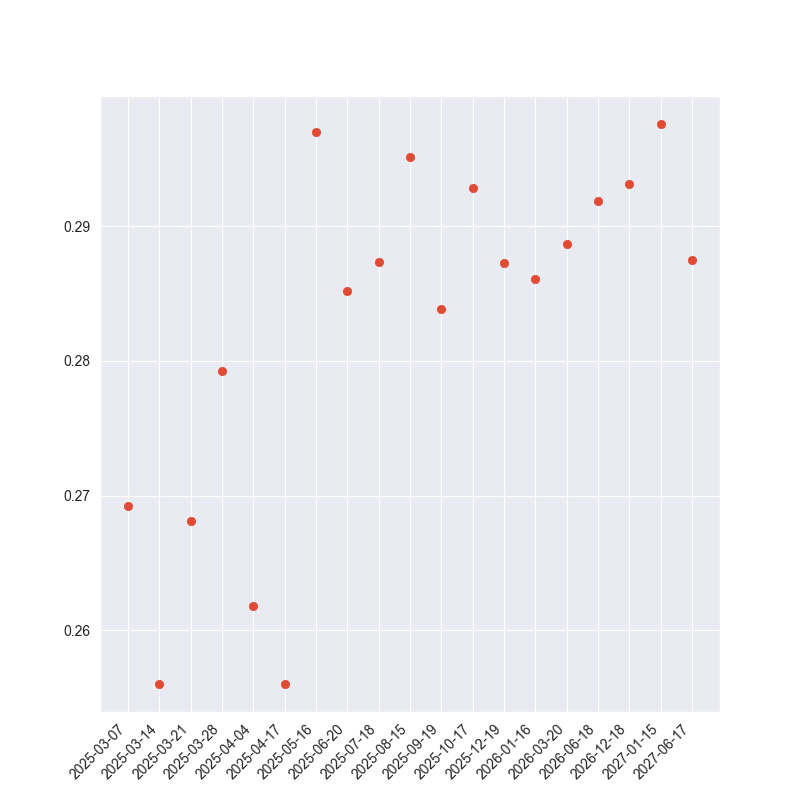

In [165]:
dates = []
ivs_at_50delta = []
for date in aapl_straddle_df_dict:
    df = aapl_straddle_df_dict[date]
    delta_interp = vol_interp_delta(df)
    iv_of_50_delta = delta_interp(0.5)
    dates.append(date)
    ivs_at_50delta.append(iv_of_50_delta)

fig = plt.figure(figsize=(8,8))
plt.scatter(dates, ivs_at_50delta)
plt.xticks(rotation=45, ha='right')
plt.show()